In [1]:
import json
from load_data.get_satellites import satellite, get_satellites
from load_data.get_ground_stations import ground_station, get_ground_station
from load_data.load_tle import parse_tle
from skyfield.api import load
from model.distribution_efficiency_sat2sat import communication_loss_sat2sat, communication_distance_sat2sat
from model.distribution_efficiency_stat2sat import communication_loss_stat2sat
from algorithm.graph import dijkstra_efficiency

In [2]:
constellation_file_path = './dataset/constellation_optimal.json' 

# read the dictionary to a file in JSON format
with open(constellation_file_path, 'r') as file:
    loaded_data = json.load(file)

constellation = loaded_data["constellation"]
ground_stations = loaded_data["ground_stations"]
graph = loaded_data["graph"]

In [3]:
city1 = 'Beijing'
city2 = 'Tokyo'
# Make sure to define your `sub_graph` before calling this function
optimal_path, efficiency = dijkstra_efficiency(graph, city1, city2)
print(f"Optimal path from {city1} to {city2} is: {optimal_path}, efficiency: {efficiency}")


Optimal path from Beijing to Tokyo is: ['Beijing', 'STARLINK-1021', 'STARLINK-1053', 'Tokyo'], efficiency: 5.7942246446643865e-09


In [4]:
city1 = 'New York'
city2 = 'Los Angeles'
# Make sure to define your `sub_graph` before calling this function
optimal_path, efficiency = dijkstra_efficiency(graph, city1, city2)
print(f"Optimal path from {city1} to {city2} is: {optimal_path}, efficiency: {efficiency}")



Optimal path from New York to Los Angeles is: ['New York', 'STARLINK-1144', 'STARLINK-1054', 'Los Angeles'], efficiency: 5.045587417391956e-10


In [5]:
city1 = 'New York'
city2 = 'Washington D.C.'
# Make sure to define your `sub_graph` before calling this function
optimal_path, efficiency = dijkstra_efficiency(graph, city1, city2)
print(f"Optimal path from {city1} to {city2} is: {optimal_path}, efficiency: {efficiency}")



Optimal path from New York to Washington D.C. is: ['New York', 'STARLINK-1144', 'Washington D.C.'], efficiency: 1.5629063975258394e-06


In [6]:
city1 = 'New York'
city2 = 'Chicago'
# Make sure to define your `sub_graph` before calling this function
optimal_path, efficiency = dijkstra_efficiency(graph, city1, city2)
print(f"Optimal path from {city1} to {city2} is: {optimal_path}, efficiency: {efficiency}")



Optimal path from New York to Chicago is: ['New York', 'STARLINK-1144', 'Chicago'], efficiency: 3.6359364601917305e-07


In [7]:
city1 = 'London'
city2 = 'Berlin'
# Make sure to define your `sub_graph` before calling this function
optimal_path, efficiency = dijkstra_efficiency(graph, city1, city2)
print(f"Optimal path from {city1} to {city2} is: {optimal_path}, efficiency: {efficiency}")

Optimal path from London to Berlin is: ['London', 'STARLINK-1971', 'Berlin'], efficiency: 6.581082544525907e-07


In [8]:
ground_stations_entity = get_ground_station()
# Path to the downloaded TLE data file
tle_path = './dataset/satellite_tle.txt'
satellite_tle_data = parse_tle(tle_path)
ts = load.timescale()
specific_time = ts.utc(2024, 1, 1, 0, 0, 0)
ground_stations_entity = get_ground_station()
#satellites_entity = get_satellites(satellite_tle_data, ts, specific_time)
links = ['New York', 'STARLINK-1144', 'STARLINK-1054', 'Los Angeles']

In [9]:
constellation_entity = {}
for sat_name, tle in satellite_tle_data.items():
    if sat_name in constellation:
        constellation_entity[sat_name] = satellite(sat_name, tle[0], tle[1], specific_time)

In [10]:
def communication_loss(link, ground_stations):
    if link[0] in ground_stations:
        #input: station, satellite
        efficiency = communication_loss_stat2sat(ground_stations_entity[link[0]], constellation_entity[link[1]]) 
    elif link[1] in ground_stations:
        efficiency = communication_loss_stat2sat(ground_stations_entity[link[1]], constellation_entity[link[0]]) 
    else:
        efficiency = communication_loss_sat2sat(constellation_entity[link[0]], constellation_entity[link[1]]) 
    return efficiency

In [11]:
# update link efficiency
def update_efficiency(links, ground_stations):
    eta_total = 1
    for i in range(len(links)-1):
        link = (links[i], links[i+1])
        #print(link)
        eta = communication_loss(link, ground_stations)
        eta_total *= eta
    return eta_total

In [12]:
links = ['New York', 'STARLINK-1144', 'Washington D.C.']
update_efficiency(links, ground_stations)

1.5629063975258394e-06

In [13]:
specific_time = ts.utc(2024, 1, 1, 0, 0, 0)
start_time = specific_time
end_time = specific_time+30

time_steps = 30*1440*60
current_time = start_time


In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta, datetime

In [33]:
efficiency_history_New_York_Washington = []
i = 0
for _ in range(time_steps):
    for sat_name, satellite in constellation_entity.items():
        if sat_name in links:
            satellite.change_time(current_time)
    # 重新计算链路效率
    eta_total = update_efficiency(links, ground_stations)
    efficiency_history_New_York_Washington.append(eta_total)
    current_time += (end_time-start_time)/time_steps

In [34]:
# Convert specific_time to a datetime object for easier manipulation
# This step assumes specific_time is a single moment; adjust if it's an array
specific_datetime = datetime(year=specific_time.utc.year,
                             month=specific_time.utc.month,
                             day=specific_time.utc.day,
                             hour=specific_time.utc.hour,
                             minute=specific_time.utc.minute,
                             second=int(specific_time.utc.second))


In [53]:
len(efficiency_history_New_York_Washington)

2592000

In [55]:
len(efficiency_history_London_Berlin)

2592000

In [57]:
efficiency_history_file_path = './dataset/efficiency_history_New_York_Washington D.C.json' 
constellation = {"efficiency_history": efficiency_history_New_York_Washington}

# Write the dictionary to a file in JSON format
with open(efficiency_history_file_path, 'w') as file:
    json.dump(efficiency_history_New_York_Washington, file)

In [40]:
import numpy as np
#draw the distribution graph
# Step 1: Convert eta to dB, filtering out zeros first
eta_history_np_New_York_Washington = np.array(efficiency_history_New_York_Washington)
eta_dB_New_York_Washington = 10 * np.log10(eta_history_np_New_York_Washington)
indices = eta_dB_New_York_Washington > -110
filtered_eta_dB_New_York_Washington = eta_dB_New_York_Washington[indices]

# Generate time data for each second
time_data = [specific_datetime + timedelta(seconds=i) for i in range(len(eta_history_np_New_York_Washington))]
filtered_times = np.array(time_data)[indices]

C:\Users\ycgao\AppData\Local\Temp\ipykernel_16456\1834915260.py:5: RuntimeWarning: divide by zero encountered in log10
  eta_dB_New_York_Washington = 10 * np.log10(eta_history_np_New_York_Washington)


E:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


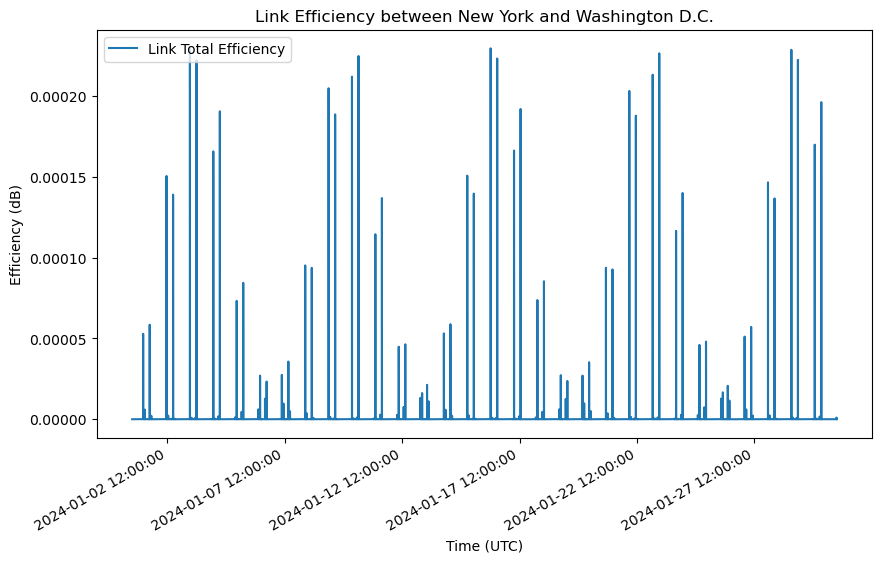

In [41]:
# 绘制效率随时间变化的图
plt.figure(figsize=(10, 6))
plt.plot(time_data,  eta_history_np_New_York_Washington, label='Link Total Efficiency')

# Formatting the date on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=120))  # Interval every hour
plt.gcf().autofmt_xdate()  # Rotate date labels automatically for better fit


# Setting labels and title
plt.xlabel('Time (UTC)')
plt.ylabel('Efficiency (dB)')
plt.title('Link Efficiency between New York and Washington D.C.')
plt.legend()
plt.grid(False)
plt.show()

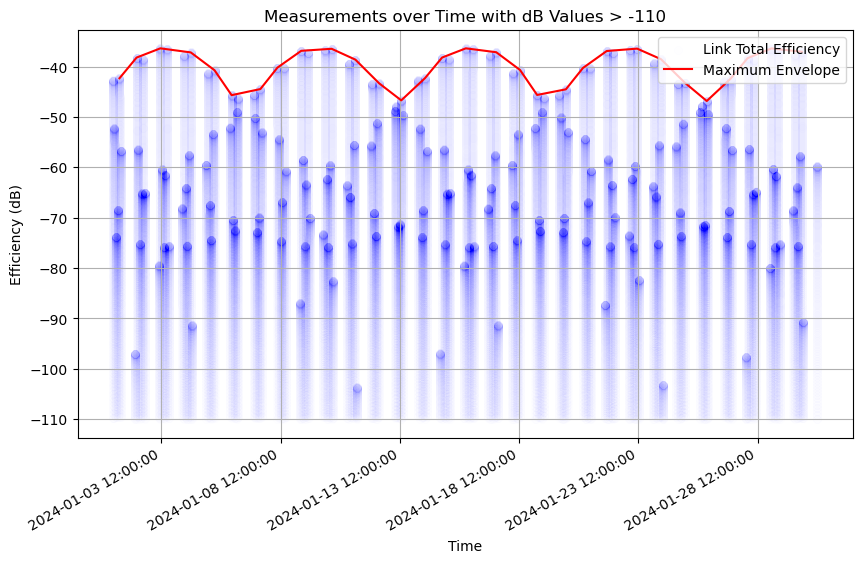

In [43]:
import pandas as pd
plt.figure(figsize=(10, 6))
plt.scatter(filtered_times, filtered_eta_dB_New_York_Washington, color='blue', alpha=0.005, label='Link Total Efficiency')

# 创建一个 DataFrame 来存储时间和值
df = pd.DataFrame({'Time': filtered_times, 'Efficiency': filtered_eta_dB_New_York_Washington})

# 舍入到最近的2小时
df['TimeRounded'] = df['Time'].dt.floor('24H')

# 定义一个函数来获取带有最大值和最小值的完整时间戳
def get_max_min_times(group):
    return pd.Series({'MaxTime': group.loc[group['Efficiency'].idxmax(), 'Time'],
                      'MaxValue': group['Efficiency'].max(),
                      'MinTime': group.loc[group['Efficiency'].idxmin(), 'Time'],
                      'MinValue': group['Efficiency'].min()})

# 应用函数并按照时间块重设索引
envelope_df = df.groupby('TimeRounded').apply(get_max_min_times).reset_index()


# 绘制包络线
plt.plot(envelope_df['MaxTime'], envelope_df['MaxValue'], label='Maximum Envelope', color='red')

#plt.plot(envelope_df.index, envelope_df[('Efficiency', 'min')], label='Minimum Envelope', color='green')


# 设置日期格式化
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=120))
plt.gcf().autofmt_xdate()  # 自动旋转日期标签以更好地适应

plt.xlabel('Time')
plt.ylabel('Efficiency (dB)')
plt.title('Measurements over Time with dB Values > -110')
plt.legend()
plt.grid(True)
plt.show()



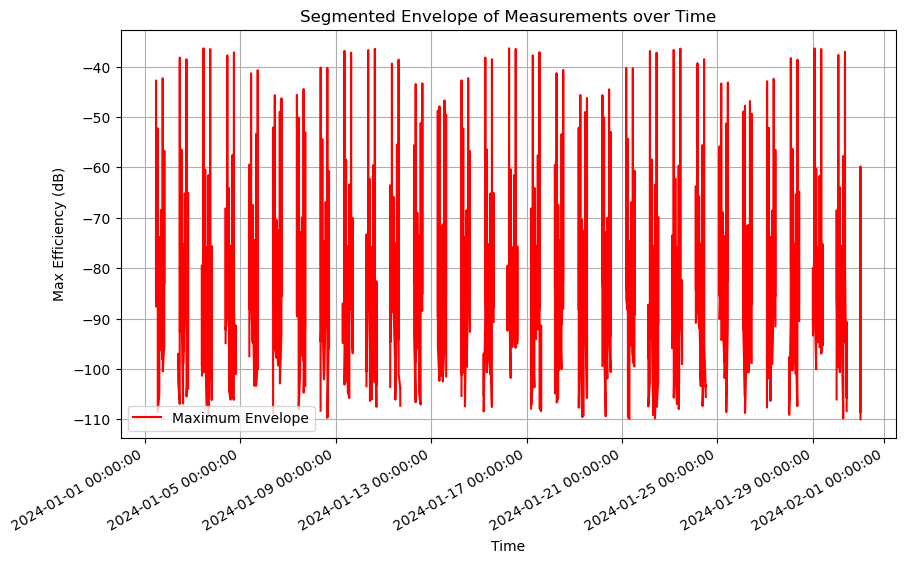

In [45]:
import pandas as pd
# 创建一个 DataFrame 来存储时间和值
df = pd.DataFrame({'Time': filtered_times, 'Efficiency': filtered_eta_dB_New_York_Washington})

# 现在我们可以按时间对数据进行分组，并找到每个时间点的最大值和最小值
envelope_df = df.groupby(pd.Grouper(key='Time', freq='Min')).agg(['min', 'max'])
envelope_df = envelope_df.dropna()

# 将包络线数据转换成DataFrame，这样更容易操作
envelope_df = envelope_df['Efficiency']['max'].reset_index()
envelope_df.columns = ['Time', 'MaxEfficiency']


# 定义断点的阈值
threshold = pd.Timedelta(hours=2)

# 计算时间差异
envelope_df['Time_diff'] = envelope_df['Time'].diff()

# 找出时间间隔大于阈值的索引
breaks = envelope_df[envelope_df['Time_diff'] > threshold].index

# 分段的起点包括第一个点
start_points = [0] + breaks.tolist()

# 分段的终点包括最后一个点
end_points = breaks.tolist() + [len(envelope_df)]

# 绘图
plt.figure(figsize=(10, 6))

# 绘制所有分段的包络线
for start, end in zip(start_points, end_points):
    segment = envelope_df.iloc[start:end]
    plt.plot(segment['Time'], segment['MaxEfficiency'], color = "red")

# 设置日期格式化
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # 自动确定日期间隔
plt.gcf().autofmt_xdate()  # 优化日期标签的显示

plt.xlabel('Time')
plt.ylabel('Max Efficiency (dB)')
plt.title('Segmented Envelope of Measurements over Time')
plt.legend(['Maximum Envelope'])
plt.grid(True)
plt.show()

# Step 2: Plotting
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(filtered_eta_dB, bins=150, density=True, alpha=0.4, color='r')  # You can adjust bins for better visualization
# 获取当前y轴的刻度位置和标签
locs, labels = plt.yticks()

# 将概率密度转换为百分比，并设置新的y轴刻度标签
plt.yticks(locs, ['{:,.2%}'.format(x) for x in locs])

plt.xlabel('Transmittance (dB)')
plt.ylabel('Distribution')
plt.title('Distribution of Transmittance: New York and Washington D.C.')
plt.grid(False)
plt.show()

In [72]:
specific_time = ts.utc(2024, 1, 1, 0, 0, 0)
start_time = specific_time-4.5/1440
end_time = specific_time+0.5/1400

time_steps = 3000
current_time = start_time


In [73]:
efficiency_history_small = []
i = 0
for _ in range(time_steps):
    for sat_name, satellite in constellation_entity.items():
        satellite.change_time(current_time)
    # 重新计算链路效率
    eta_total = update_efficiency(links, ground_stations)
    efficiency_history_small.append(eta_total)
    current_time += (end_time-start_time)/time_steps

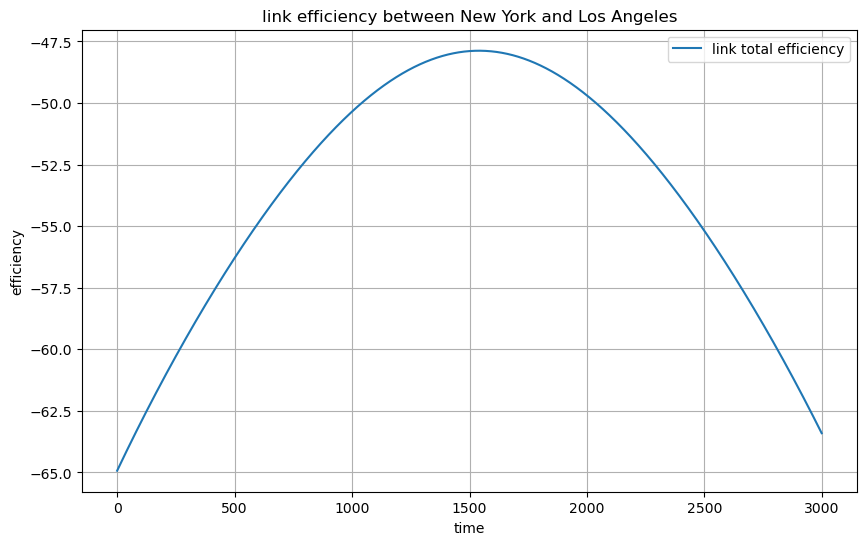

In [74]:
# 绘制效率随时间变化的图
plt.figure(figsize=(10, 6))
plt.plot(10 * np.log10(efficiency_history_small), label='link total efficiency')
plt.xlabel('time')
plt.ylabel('efficiency')
plt.title('link efficiency between New York and Los Angeles')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
links = ['London', 'STARLINK-1200', 'Berlin']
update_efficiency(links, ground_stations)

4.00259048089709e-05

In [49]:
specific_time = ts.utc(2024, 1, 1, 0, 0, 0)
start_time = specific_time
end_time = specific_time+30

time_steps = 30*1440*60
current_time = start_time


In [50]:
efficiency_history_London_Berlin = []
i = 0
for _ in range(time_steps):
    for sat_name, satellite in constellation_entity.items():
        if sat_name in links:
            satellite.change_time(current_time)
    # 重新计算链路效率
    eta_total = update_efficiency(links, ground_stations)
    efficiency_history_London_Berlin.append(eta_total)
    current_time += (end_time-start_time)/time_steps

In [51]:
import numpy as np
#draw the distribution graph
# Step 1: Convert eta to dB, filtering out zeros first
eta_history_np_London_Berlin = np.array(efficiency_history_London_Berlin)
eta_dB_London_Berlin = 10 * np.log10(eta_history_np_London_Berlin)
indices = eta_dB_London_Berlin > -110
filtered_eta_dB_London_Berlin = eta_dB_London_Berlin[indices]

# Generate time data for each second
time_data = [specific_datetime + timedelta(seconds=i) for i in range(len(eta_history_np_London_Berlin))]
filtered_times = np.array(time_data)[indices]

C:\Users\ycgao\AppData\Local\Temp\ipykernel_13076\3813192504.py:5: RuntimeWarning: divide by zero encountered in log10
  eta_dB = 10 * np.log10(eta_history_np)


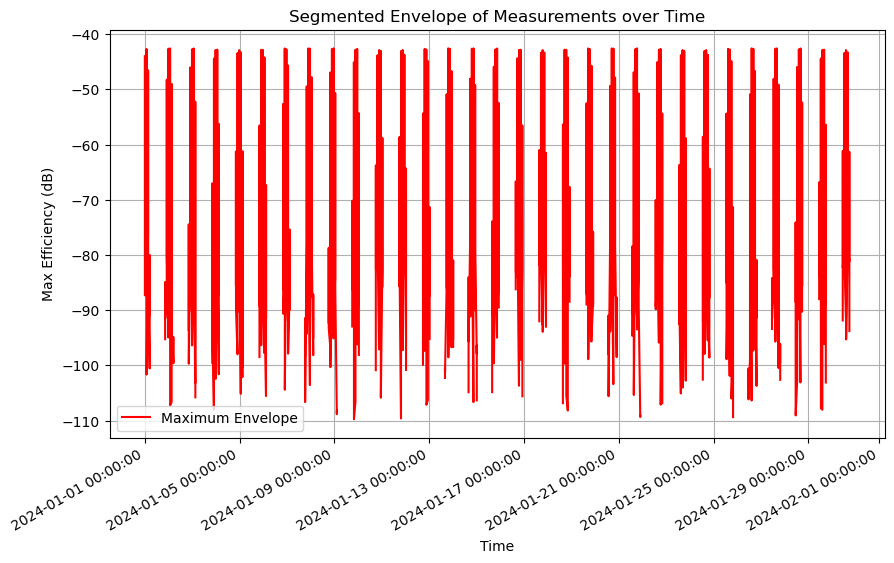

In [52]:
import pandas as pd
# 创建一个 DataFrame 来存储时间和值
df = pd.DataFrame({'Time': filtered_times, 'Efficiency': filtered_eta_dB_London_Berlin})

# 现在我们可以按时间对数据进行分组，并找到每个时间点的最大值和最小值
envelope_df = df.groupby(pd.Grouper(key='Time', freq='Min')).agg(['min', 'max'])
envelope_df = envelope_df.dropna()

# 将包络线数据转换成DataFrame，这样更容易操作
envelope_df = envelope_df['Efficiency']['max'].reset_index()
envelope_df.columns = ['Time', 'MaxEfficiency']


# 定义断点的阈值
threshold = pd.Timedelta(hours=2)

# 计算时间差异
envelope_df['Time_diff'] = envelope_df['Time'].diff()

# 找出时间间隔大于阈值的索引
breaks = envelope_df[envelope_df['Time_diff'] > threshold].index

# 分段的起点包括第一个点
start_points = [0] + breaks.tolist()

# 分段的终点包括最后一个点
end_points = breaks.tolist() + [len(envelope_df)]

# 绘图
plt.figure(figsize=(10, 6))

# 绘制所有分段的包络线
for start, end in zip(start_points, end_points):
    segment = envelope_df.iloc[start:end]
    plt.plot(segment['Time'], segment['MaxEfficiency'], color = "red")

# 设置日期格式化
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # 自动确定日期间隔
plt.gcf().autofmt_xdate()  # 优化日期标签的显示

plt.xlabel('Time')
plt.ylabel('Max Efficiency (dB)')
plt.title('Segmented Envelope of Measurements over Time')
plt.legend(['Maximum Envelope'])
plt.grid(True)
plt.show()

In [53]:
len(filtered_times)

75216

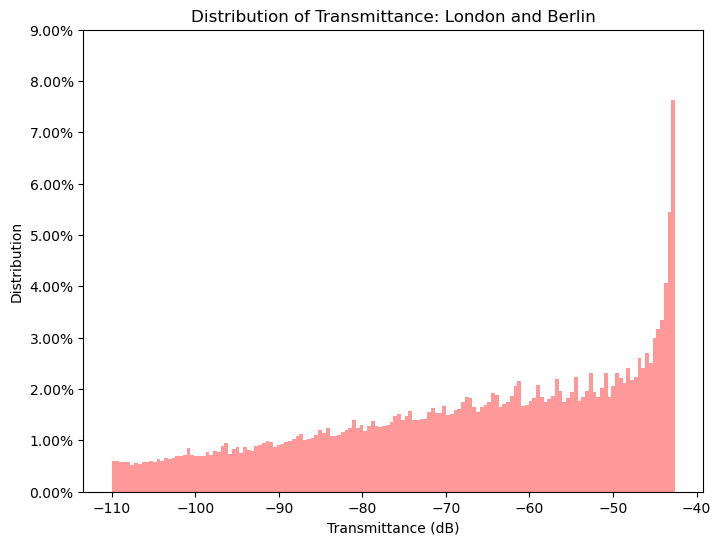

In [55]:
# Step 2: Plotting
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(filtered_eta_dB_London_Berlin, bins=150, density=True, alpha=0.4, color='r')  # You can adjust bins for better visualization
# 获取当前y轴的刻度位置和标签
locs, labels = plt.yticks()

# 将概率密度转换为百分比，并设置新的y轴刻度标签
plt.yticks(locs, ['{:,.2%}'.format(x) for x in locs])

plt.xlabel('Transmittance (dB)')
plt.ylabel('Distribution')
plt.title('Distribution of Transmittance: London and Berlin')
plt.grid(False)
plt.show()

In [56]:
efficiency_history_file_path = './dataset/efficiency_history_London_Berlin.json' 
constellation = {"efficiency_history": efficiency_history_London_Berlin}

# Write the dictionary to a file in JSON format
with open(efficiency_history_file_path, 'w') as file:
    json.dump(efficiency_history_London_Berlin, file)

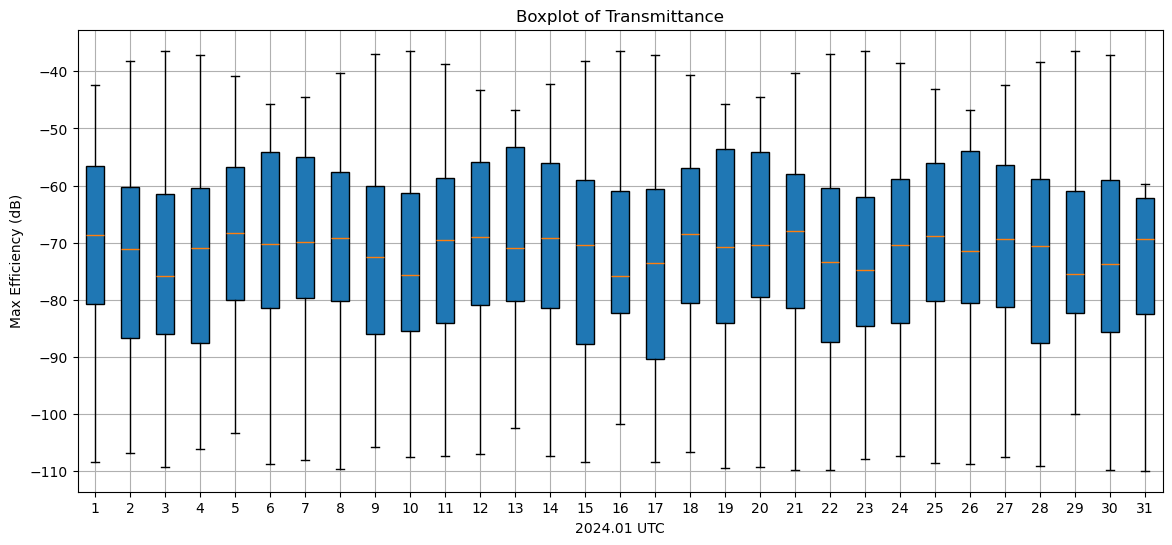

In [51]:
# 分段数据准备
segmented_data = []

for start, end in zip(start_points, end_points):
    segment = envelope_df.iloc[start:end]
    if not segment.empty:
        # 添加分段数据到列表
        segmented_data.append(segment['MaxEfficiency'].tolist())

# 绘制箱线图
plt.figure(figsize=(14, 6))
plt.boxplot(segmented_data, showfliers=True, patch_artist=True)  # 显示异常值，用颜色填充箱体

# 设置箱线图的x轴标签
#plt.xticks(range(1, len(segmented_data) + 1), ['Segment {}'.format(i) for i in range(1, len(segmented_data) + 1)])

plt.xlabel('2024.01 UTC')
plt.ylabel('Max Efficiency (dB)')
plt.title('Boxplot of Transmittance')
plt.grid(True)
plt.show()

In [121]:
links = ['New York', 'STARLINK-1144']

In [134]:
specific_time = ts.utc(2024, 1, 1, 0, 0, 0)
start_time = specific_time-5.5/1440
end_time = specific_time+2.5/1440

time_steps = 4800
current_time = start_time


In [135]:
efficiency_history_New_York_Starlink_1144 = []
i = 0
for _ in range(time_steps):
    for sat_name, satellite in constellation_entity.items():
        satellite.change_time(current_time)
    # 重新计算链路效率
    eta_total = update_efficiency(links, ground_stations)
    efficiency_history_New_York_Starlink_1144.append(eta_total)
    current_time += (end_time-start_time)/time_steps

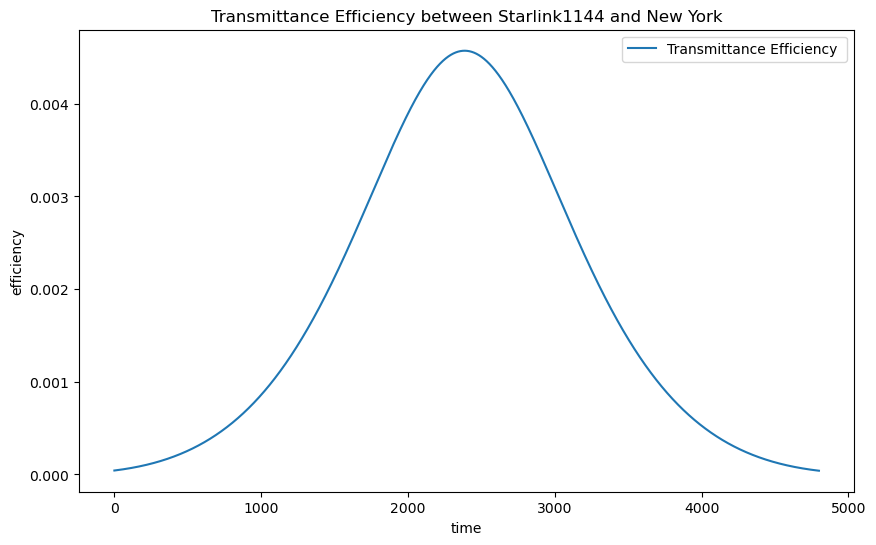

In [136]:
efficiency_dB = 10 * np.log10(np.array(efficiency_history_New_York_Starlink_1144))
# 绘制效率随时间变化的图
plt.figure(figsize=(10, 6))
plt.plot(efficiency_history_New_York_Starlink_1144, label='Transmittance Efficiency ')
plt.xlabel('time')
plt.ylabel('efficiency')
plt.title('Transmittance Efficiency between Starlink1144 and New York')
plt.legend()
plt.grid(False)
plt.show()

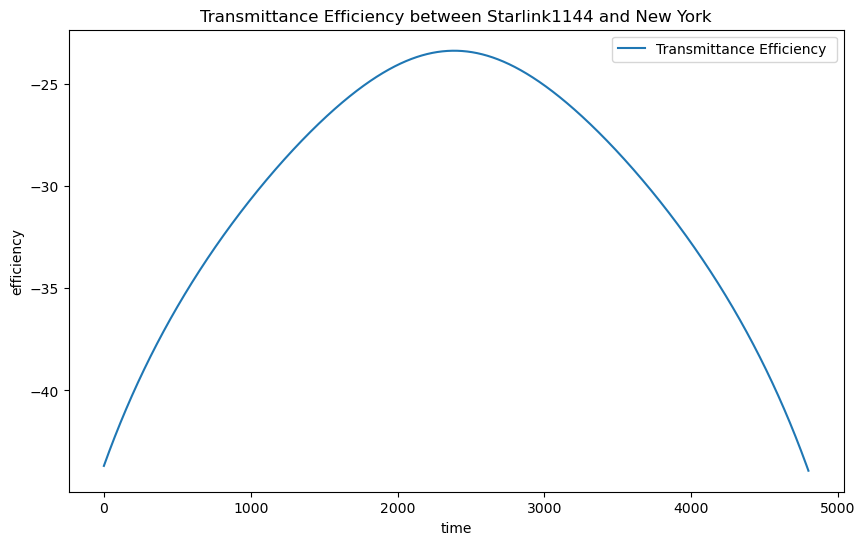

In [137]:
efficiency_dB = 10 * np.log10(np.array(efficiency_history_New_York_Starlink_1144))
# 绘制效率随时间变化的图
plt.figure(figsize=(10, 6))
plt.plot(efficiency_dB, label='Transmittance Efficiency ')
plt.xlabel('time')
plt.ylabel('efficiency')
plt.title('Transmittance Efficiency between Starlink1144 and New York')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
links = ['STARLINK-1144', 'STARLINK-1054']

In [15]:
specific_time = ts.utc(2024, 1, 1, 0, 0, 0)
start_time = specific_time
end_time = specific_time+30

time_steps = 30*1440*60
current_time = start_time


In [16]:
efficiency_history = []
i = 0
for _ in range(time_steps):
    for sat_name, satellite in constellation_entity.items():
        satellite.change_time(current_time)
    # 重新计算链路效率
    #eta_total = update_efficiency(links, ground_stations)
    eta_total = communication_loss_sat2sat(constellation_entity['STARLINK-1971'], constellation_entity['STARLINK-2024']) 
    efficiency_history.append(eta_total)
    current_time += (end_time-start_time)/time_steps

KeyboardInterrupt: 

In [ ]:
len(efficiency_history)# 绘制效率随时间变化的图
plt.figure(figsize=(10, 6))
plt.plot(efficiency_history, label='Transmittance Efficiency ')
plt.xlabel('time')
plt.ylabel('efficiency')
plt.title('Transmittance Efficiency between Starlink1144 and New York')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
specific_time = ts.utc(2024, 1, 1, 0, 0, 0)
start_time = specific_time-100/1440
end_time = specific_time+100/1440

time_steps = 12000
current_time = start_time


In [71]:
# Convert specific_time to a datetime object for easier manipulation
# This step assumes specific_time is a single moment; adjust if it's an array
specific_datetime = datetime(year=specific_time.utc.year,
                             month=specific_time.utc.month,
                             day=specific_time.utc.day,
                             hour=specific_time.utc.hour,
                             minute=specific_time.utc.minute,
                             second=int(specific_time.utc.second))


In [87]:
start_datetime = datetime(year=start_time.utc.year,
                             month=start_time.utc.month,
                             day=start_time.utc.day,
                             hour=start_time.utc.hour,
                             minute=start_time.utc.minute,
                             second=int(start_time.utc.second))

In [81]:
efficiency_history = []
distance_history = []
i = 0
for _ in range(time_steps):
    for sat_name, satellite in constellation_entity.items():
        satellite.change_time(current_time)
    # 重新计算链路效率
    #eta_total = update_efficiency(links, ground_stations)
    eta_total = communication_loss_sat2sat(constellation_entity['STARLINK-1971'], constellation_entity['STARLINK-2024']) 
    distance = communication_distance_sat2sat(constellation_entity['STARLINK-1971'], constellation_entity['STARLINK-2024'])
    efficiency_history.append(eta_total)
    distance_history.append(distance)
    current_time += (end_time-start_time)/time_steps

In [106]:
time_data = [specific_datetime - timedelta(seconds=6000) + timedelta(seconds=i) for i in range(len(efficiency_history))]
efficiency_dB = 10 * np.log10(np.array(efficiency_history) )


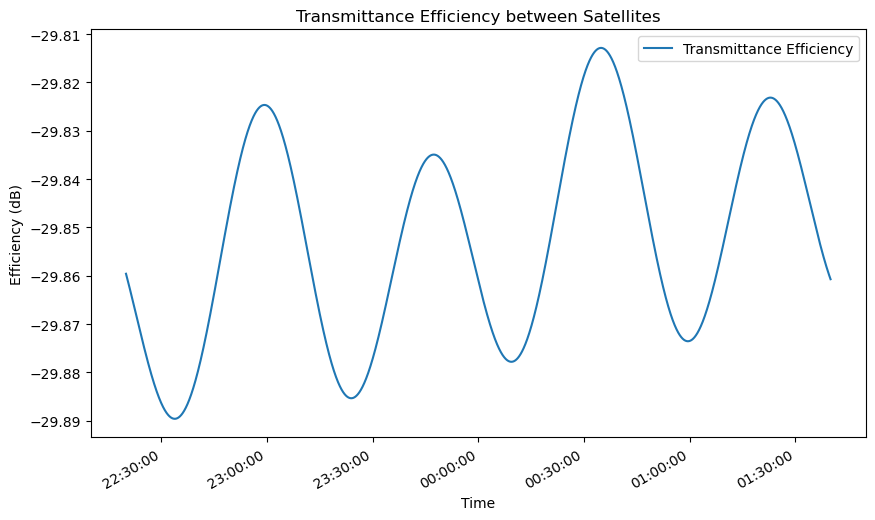

In [108]:
# 绘制效率随时间变化的图
plt.figure(figsize=(10, 6))
plt.plot(time_data, efficiency_dB, label='Transmittance Efficiency')

# 设置日期格式化
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # 自动确定日期间隔
plt.gcf().autofmt_xdate()  # 优化日期标签的显示

plt.xlabel('Time')
plt.ylabel('Efficiency (dB)')
plt.title('Transmittance Efficiency between Satellites')
plt.legend()
plt.grid(False)
plt.show()

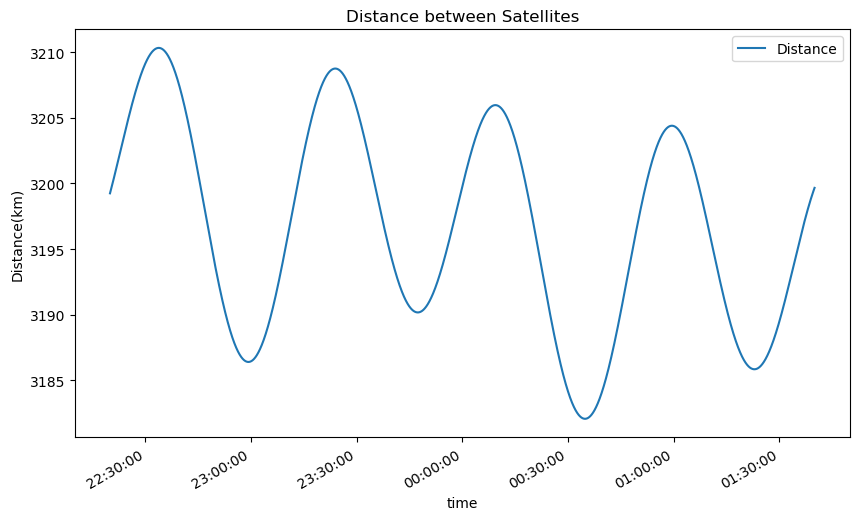

In [120]:
len(efficiency_history)# 绘制效率随时间变化的图
plt.figure(figsize=(10, 6))
plt.plot(time_data, distance_history, label='Distance')

#plt.plot(local_max_times_first, [distance_history[time_data.index(t)] for t in local_max_times_first], 'r')

# 设置日期格式化
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # 自动确定日期间隔
plt.gcf().autofmt_xdate()  # 优化日期标签的显示

plt.xlabel('time')
plt.ylabel('Distance(km)')
plt.title('Distance between Satellites')
plt.legend()
plt.grid(False)
plt.show()

In [113]:
# Find local max and min for first TLE
def find_local_extremes(distances, times, window=5):
    local_max_times = []
    local_min_times = []
    for i in range(window, len(distances) - window):
        is_max = all(distances[i] > distances[i + j] for j in range(-window, window + 1) if j != 0)
        is_min = all(distances[i] < distances[i + j] for j in range(-window, window + 1) if j != 0)
        if is_max:
            local_max_times.append(times[i])
        if is_min:
            local_min_times.append(times[i])
    return local_max_times, local_min_times

In [116]:
local_max_times_first, local_min_times_first = find_local_extremes(efficiency_dB, time_data ,16)

In [117]:
local_max_times_first, local_min_times_first

([datetime.datetime(2023, 12, 31, 22, 59, 17),
  datetime.datetime(2023, 12, 31, 23, 47, 22),
  datetime.datetime(2024, 1, 1, 0, 34, 50),
  datetime.datetime(2024, 1, 1, 1, 22, 55)],
 [datetime.datetime(2023, 12, 31, 22, 33, 50),
  datetime.datetime(2023, 12, 31, 23, 23, 56),
  datetime.datetime(2024, 1, 1, 0, 9, 23),
  datetime.datetime(2024, 1, 1, 0, 59, 29)])

0.1388773148148148

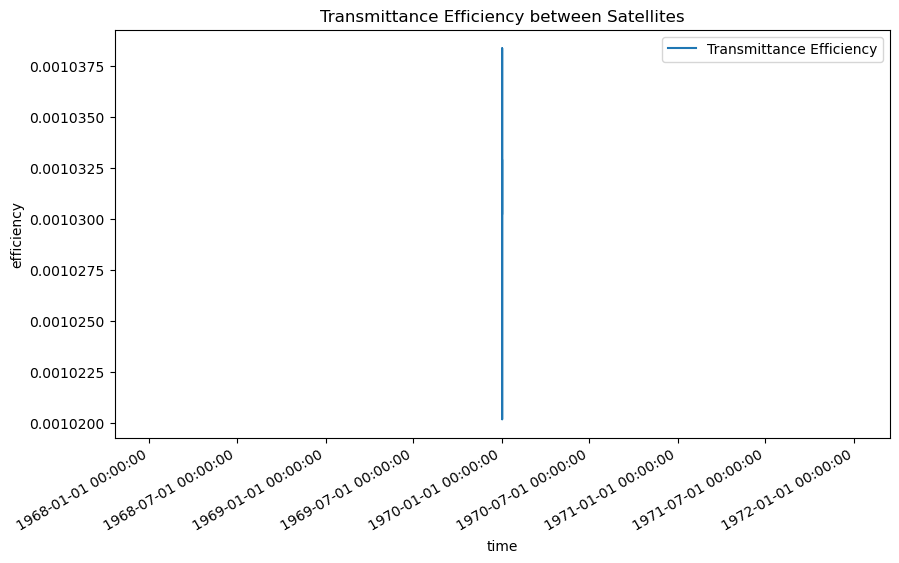

In [79]:
# 绘制效率随时间变化的图
plt.figure(figsize=(10, 6))
plt.plot(np.array(time_data), efficiency_history, label='Transmittance Efficiency')

# 设置日期格式化
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # 自动确定日期间隔
plt.gcf().autofmt_xdate()  # 优化日期标签的显示

plt.xlabel('time')
plt.ylabel('efficiency')
plt.title('Transmittance Efficiency between Satellites')
plt.legend()
plt.grid(False)
plt.show()

In [78]:
time_data = np.ones(len(efficiency_history))